# Startle behavior plots

Run this notebook to reproduce plots in Fig 1 & 2 on the directional startle behavior of _Danionella cerebrum_.  
To run the same analysis for a second dataset on lateral line ablated fish, set `lla_control_data` to `True`.

## Imports and helper functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
def ax_format(ax):
    ax.set_xlim([-2.1,2.1])
    ax.set_ylim([-2.1,2.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['right', 'top', 'left','bottom']].set_visible(False)
    ax.set_aspect('equal')

def ax_ctr_trajectories(df,groupby,group,start,stop,ax,plt_hist=True,xaway=False,Bonf_corr=0):
    """
    This function plots centered displacement trajectories of fish based on the provided DataFrame.

    Parameters:
    df (DataFrame): The DataFrame containing the fish data.
    groupby (str): The column name to group the DataFrame by.
    group (str): The specific group to select from the DataFrame.
    start (int): The start index for slicing the DataFrame. Before startle initiation.
    stop (int): The stop index for slicing the DataFrame. End of initial startle phase.
    ax (matplotlib axis): Matplotlib axis for plotting
    plt_hist (bool, optional): If True, plots a histogram below the trajectories. Defaults to True.
    xaway (bool, optional): If True, uses 's7_x_cm_away'. If False, uses 's7_x_cm'. Defaults to False.
    Bonf_corr (int, optional): Number of comparisons for Bonferroni correction. If 0, no correction.

    Returns:
    None
    """
    # grouping
    tmp = df[(df[groupby]==group)]
    nfish = len(tmp['fish_id'].unique())

    # displacements
    if xaway:
        xtmp = np.stack(tmp['s7_x_cm_away'].values).T[:,tmp['startle']]
        hist_color = "Blues"
    else:
        xtmp = np.stack(tmp['s7_x_cm'].values).T[:,tmp['startle']]
        hist_color = "Greys"

    ytmp = np.stack(tmp['s7_y_cm'].values).T[:,tmp['startle']]
    xtmp=np.squeeze(xtmp[start:stop+1])
    ytmp=np.squeeze(ytmp[start:stop+1])
    xtmp -= xtmp[0]
    ytmp -= ytmp[0]

    idxright = xtmp[-1]>xtmp[0]
    toright = np.sum(idxright)
    idxleft = xtmp[-1]<=xtmp[0]
    toleft = np.sum(idxleft)

    # plot histogram
    if plt_hist:
        hist, _, _, _ = ax.hist2d(xtmp[-1,idxright+idxleft], ytmp[-1,idxright+idxleft], bins=8, range=[[-1.5, 1.5], [-1.5, 1.5]],cmap=hist_color)
        interpolate = 1
        if interpolate:
            ax.clear()
            ax.imshow(hist.T, origin = "lower", interpolation = "gaussian", extent=[-1.5,1.5,-1.5,1.5], cmap=hist_color, alpha=.7)
        ax.set_aspect('equal')

    # plot trajectories
    ax.plot(xtmp[:,idxright+idxleft], ytmp[:,idxright+idxleft], '-', lw=1, color='k', alpha=0.2,zorder=3)

    # plot origin
    ax.axvline(0,-1.5,1.5,ls='--',lw=1.5,color='black',alpha=.3,zorder=9)
    ax.scatter(0, 0, marker='o', s=80,color='white', alpha=1,zorder=10)
    ax.spines[['right', 'top', 'left','bottom']].set_visible(False)

    # statistics
    frac_toright = toright/(toright+toleft)
    p = scipy.stats.binomtest(toright, toright+toleft, 0.5, alternative='two-sided').pvalue
    Bonf_flag = ""
    if Bonf_corr != 0:
        p *= Bonf_corr
        Bonf_flag = f"\nBonf. corrected: n={Bonf_corr}"

    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    ax.set_aspect('equal')
    ax.set_title(f'{group}\n {(frac_toright*100):.1f}% of {toright+toleft},\np = {p:.1g}, {nfish} fish{Bonf_flag}')


def plot():
    n = len(groups)
    fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(6*n,10))

    for i, group in enumerate(groups):
        print(group)
        if n==1:
            ax = axs
        else:
            ax = axs[i]
        ax_ctr_trajectories(df,groupby,group,f1,f2,ax=ax,plt_hist=True,xaway=xaway)
        ax.set_xticks([])
        if i!=0:
            ax.set_yticks([])
        else:
            ax.set_ylabel("y [cm]")

    if xaway:
        flip = ", Sp1 traj. mirrored"
    else:
        flip = ""

    fig.tight_layout()
    fig.subplots_adjust(top=1.15)
    plt.suptitle(f"Endpoints of centered trajectories of startles {flip}\nstart: %.2fs, stop: %.2fs (relative to trigger frame)\n" %((f1-f0)/frate,(f2-f0)/frate))
    return fig, axs

## Get data
lla - lateral line ablation  

`lla_control_data =  False` gets data for Fig. 1 & 2, as well as Extended Data Fig. 2, 3, 4, 5, 7 & 8  
`lla_control_data =  True` gets data for Extended Data Fig. 3, 6 & 7

In [3]:
# Get data
lla_control_data = False

if lla_control_data:
    !wget "https://charitede-my.sharepoint.com/:u:/g/personal/johannes_veith_charite_de/Ebzjmkk60KpKjB9DUTF9ZHQBrswzem1bhM6J17xJcfNgGw?e=4NEKcQ&download=1" -O 74fish_withlla.zip
    df = pd.read_pickle('74fish_withlla.zip')
else:
    !wget "https://charitede-my.sharepoint.com/:u:/g/personal/johannes_veith_charite_de/EWM3hni-4RxBu2-2QDeKf1ABGMR3nAnS3U1E1xkNoVrzcA?e=8gmA6v&download=1" -O 65fish_nolla.zip
    df = pd.read_pickle('65fish_nolla.zip')
df

--2024-01-29 13:00:29--  https://charitede-my.sharepoint.com/:u:/g/personal/johannes_veith_charite_de/EWM3hni-4RxBu2-2QDeKf1ABGMR3nAnS3U1E1xkNoVrzcA?e=8gmA6v&download=1
Resolving charitede-my.sharepoint.com (charitede-my.sharepoint.com)... 13.107.136.10, 13.107.138.10, 2620:1ec:8f8::10, ...
Connecting to charitede-my.sharepoint.com (charitede-my.sharepoint.com)|13.107.136.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/johannes_veith_charite_de/Documents/toshare/startledata/65fish_nolla.zip?ga=1 [following]
--2024-01-29 13:00:30--  https://charitede-my.sharepoint.com/personal/johannes_veith_charite_de/Documents/toshare/startledata/65fish_nolla.zip?ga=1
Reusing existing connection to charitede-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 404008145 (385M) [application/x-zip-compressed]
Saving to: ‘65fish_nolla.zip’

65fish_nolla.zip    100%[===================>] 385.29M  20.5MB/s    in 13s     

2024-01-29 13:00

,fish_id,played_at_frame,sex,slp_x,slp_y,slp_instance_scores,nthplayback,Type,TypeShort,Speaker,allinv,thenPressureInv,"Pressure, Motion",Pressure,Motion,signal,s7_x_cm,s7_y_cm,s7_v_cmps
0,0,200716,f,"[[nan, 211.8157501220703, 205.466552734375, 19...","[[nan, 60.706153869628906, 60.88592529296875, ...","[6.38746452331543, 6.386748790740967, 6.387108...",1,Rubber Drop,R,sp0,False,False,"+1,+1",+1,+1,"R, sp0, +1,+1","[5.972680041664525, 5.972691084209241, 5.97278...","[9.005681840996992, 9.005673182638068, 9.00571...","[0.0016838739893729826, 0.01287967444637402, 0..."
1,0,279113,f,"[[nan, 207.53028869628906, 204.47227478027344,...","[[nan, 302.5726013183594, 296.5616149902344, 2...","[6.337522029876709, 6.273736476898193, 6.28044...",2,Rubber Drop,R,sp0-4,False,False,"+1,0",+1,0,"R, sp0-4, +1,0","[6.422224044799805, 6.4226537001760375, 6.4219...","[1.9915229395816199, 1.9951780218827095, 1.997...","[0.4416298419818729, 0.29070017469968046, 0.04..."
2,1,36194,m,"[[nan, 155.97048950195312, 155.01287841796875,...","[[nan, 266.10137939453125, 270.58587646484375,...","[6.874357223510742, 6.877198696136475, 6.87728...",1,Rubber Drop,R,sp0-4,False,False,"0,+1",0,+1,"R, sp0-4, 0,+1","[5.008366735357987, 5.008496736225329, 5.00840...","[1.5408636394299957, 1.5407873454846832, 1.540...","[0.018088180645252267, 0.022173581042601642, 0..."
3,1,38289,m,"[[nan, 152.6046600341797, 152.67872619628906, ...","[[nan, 265.3077392578125, 260.2356872558594, 2...","[7.041740417480469, 7.0453691482543945, 7.0389...",2,Rubber Drop,R,sp0,False,False,"+1,+1",+1,+1,"R, sp0, +1,+1","[5.052899310463353, 5.052675447965923, 5.05254...","[3.1562092429713196, 3.1575805262515417, 3.159...","[0.16673231370722352, 0.17438167089595308, 0.0..."
4,1,40636,m,"[[nan, 142.38015747070312, 144.39463806152344,...","[[nan, 295.9375305175781, 300.3948059082031, 3...","[4.738778114318848, 4.560036659240723, 4.66291...",3,Rubber Drop,R,sp0,False,False,"+1,+1",+1,+1,"R, sp0, +1,+1","[9.74903809396844, 9.749039097836143, 9.749040...","[9.621753692626953, 9.621753818110415, 9.62175...","[0.00012140160234989444, 0.0002171697883690580..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,64,340435,f,"[[nan, 237.8394012451172, 242.09056091308594, ...","[[nan, 281.72222900390625, 284.8876953125, 287...","[4.523582458496094, 4.451993465423584, 4.34853...",32,Rubber Drop,R,sp0,True,True,"+1,-1",+1,-1,"R, sp0, +1,-1","[8.427012594122635, 8.431326213635895, 8.43434...","[1.3112228795101768, 1.3063250089946545, 1.301...","[0.7831914606562056, 0.6435251355031646, 0.949..."
3794,64,350530,f,"[[nan, 220.52557373046875, 219.80535888671875,...","[[nan, 163.82208251953125, 158.12051391601562,...","[6.8847174644470215, 6.938261985778809, 7.0178...",33,Rubber Drop,R,sp0,False,False,"+1,+1",+1,+1,"R, sp0, +1,+1","[7.150186237535978, 7.149204956857782, 7.14785...","[6.557682438900596, 6.560916900634766, 6.56436...","[0.4056045173573011, 0.44488928036868763, 0.45..."
3795,64,352315,f,"[[nan, 276.49700927734375, 274.8659362792969, ...","[[nan, 217.59393310546875, 223.26910400390625,...","[6.648095607757568, 6.6753764152526855, 6.5911...",34,Rubber Drop,R,sp1,False,False,"+1,+1",+1,+1,"R, sp1, +1,+1","[8.92556441457648, 8.924130891498766, 8.923641...","[2.9859221609015214, 2.9822595495926705, 2.979...","[0.47197862684919156, 0.33372417461379944, 0.4..."
3796,64,353115,f,"[[172.53297424316406, 173.40957641601562, 174....","[[149.794677734375, 145.6897430419922, 139.234...","[6.953117370605469, 6.840521812438965, 6.83547...",35,Rubber Drop,R,sp0,False,False,"+1,+1",+1,+1,"R, sp0, +1,+1","[5.978430697792454, 5.98805076197574, 5.999197...","[7.14031646126195, 7.160763489572625, 7.191579...","[2.7116458219030997, 3.9324188440735757, 2.929..."


### The dataframe object
Playbacks were triggered in the trigger zone at the tank's center. Each dataframe row contains one playack event.
Fish trajectories are centered on the playback video frame and contain 5s before and 7s after playback trigger.  


### Coordinate columns
`slp_x` and `slp_y`

contain coordinates for all nine SLEAP nodes:
```
['s1', 's2', 's3', 's4', 's5', 's6', 's7', 'left_eye', 'right_eye']  

s1 to s4 - tail  
s5 - caudal swimbladder  
s6 - rostral swimbladder
s7 - head   
```
  
`s7_x_cm`, `s7_y_cm` and `s7_v_cmps`
contain interpolated trajectories for the head node `s7`, filtered for successful tracking and converted into centimeters or centimeters per second (cmps).

In [4]:
## Parameters

# Camera
cmppx = 0.03289473684210526 # centimeters per pixel
w = 336 # video width
h = 336 # video height
frate = 120 # video framerate

# Startle detection
v_thr = 17 # threshold for temporal mean speed
thr_f0 = 609 # start of temporal window
thr_f1 = 612 # end of temporal window

# Timing
f0 = 600 # data is centered on this playback trigger frame
f1 = 605 # frame before startle initialization
f2 = 611 # frame when initial startle phase ends

# Node names for SLEAP tracking
slp_node_names = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 'left_eye', 'right_eye']

___

Startles are detected via a speed threshold after playback.
To pool over startle trajectories after playback from a left speaker and playback from a right speaker, trajectories following right speaker playback were mirrored in a new column name `s7_x_cm_away`. Positive displacement is then a displacement directed away from the speaker.  
We pool data over different stimulus configurations below.

In [5]:
# Core analysis & grouping over stimuli
x = np.stack(df["s7_x_cm"].values)
y = np.stack(df["s7_y_cm"].values)
v = np.stack(df["s7_v_cmps"].values)
t = (np.arange(x.shape[1]) - f0)/frate
tv = t[:-1] + 0.5 / frate

startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr
df['startle'] = startle

# Flip trajectories of right speaker
df['s7_x_cm_away'] = df['s7_x_cm']
msk = df['Speaker']=='sp1'
df.loc[msk,'s7_x_cm_away'] = -df['s7_x_cm_away'][msk] # flip trajectory for right speaker to turn into an away signal

# Trick conditions (pressure inversion)
df['SpeakerTrick'] = df['Speaker'] + df['thenPressureInv'].map({True: '_Trick', False: ''})

# Pooling of Left/Right and polarity
df['Pooled'] = "FourSpeakers"
df.loc[(df['Speaker'] == 'sp0') & ~df['thenPressureInv'],'Pooled'] = "SingleSpeaker"
df.loc[(df['Speaker'] == 'sp1') & ~df['thenPressureInv'],'Pooled'] = "SingleSpeaker"
df.loc[(df['Speaker'] == 'sp0') & df['thenPressureInv'],'Pooled'] =  "Trick"
df.loc[(df['Speaker'] == 'sp1') & df['thenPressureInv'],'Pooled'] =  "Trick"

# Split polarities
df['Pooled, Pressure Polarity'] = df['Pooled'] + df['Pressure']

<ipython-input-5-8f1ed987a881>:8: RuntimeWarning: Mean of empty slice
  startle = np.nanmean(abs(v[:,thr_f0:thr_f1]),axis=1) > v_thr


Names of groups after pooling

In [6]:
# Waveform name (all `R` for `Rubberdrop`), active speakers, pressure polarity, motion polarity
# polarity: + is postive, 0 is zero amplitude, - is negative
print(df['signal'].unique())

['R, sp0, +1,+1' 'R, sp0-4, +1,0' 'R, sp0-4, 0,+1' 'R, sp1, +1,-1'
 'R, sp0-4, -1,0' 'R, sp0, +1,-1' 'R, sp0, -1,-1' 'R, sp0-4, 0,-1'
 'R, sp0, -1,+1' 'R, sp1, -1,-1' 'R, sp1, +1,+1' 'R, sp1, -1,+1']


In [7]:
print(df['Pooled, Pressure Polarity'].unique())

['SingleSpeaker+1' 'FourSpeakers+1' 'FourSpeakers0' 'Trick+1'
 'FourSpeakers-1' 'SingleSpeaker-1' 'Trick-1']


In [8]:
print(df['SpeakerTrick'].unique())

['sp0' 'sp0-4' 'sp1_Trick' 'sp0_Trick' 'sp1']


In [9]:
print(df['Pooled'].unique())

['SingleSpeaker' 'FourSpeakers' 'Trick']


### Figure 1

#### Fig 1e | Startle classification

(None,
 Text(0.5, 1.0, 'Fish Speed around playback events\n'),
 <matplotlib.legend.Legend at 0x7bb9e97ce9e0>)

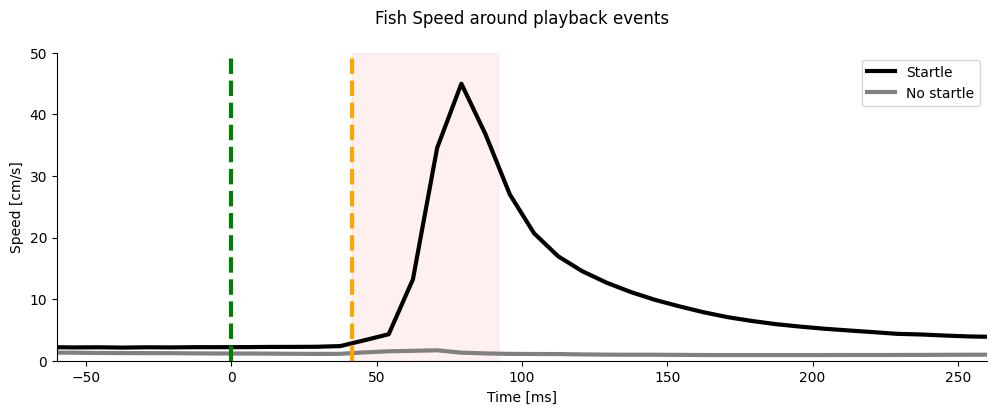

In [10]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(1e3*tv,np.nanmean(v[startle],axis=0), c='k', lw=3, label='Startle')
ax.plot(1e3*tv,np.nanmean(v[~startle],axis=0), c='gray', lw=3, label='No startle')
plt.axvline(0,ls='--',c='g',lw=3)
plt.axvspan(1e3*((f1-f0)/frate),1e3*((f2-f0)/frate),color='red',alpha=.06)
plt.axvline(1e3*((f1-f0)/frate),ls='--',lw=3,c='orange')
ax.set_ylabel("Speed [cm/s]"), ax.set_xlabel("Time [ms]"), ax.set_xlim([-60,260]), ax.set_ylim([0,50])
ax.spines[['top','right']].set_visible(False), ax.set_title("Fish Speed around playback events\n"), ax.legend(loc="upper right")

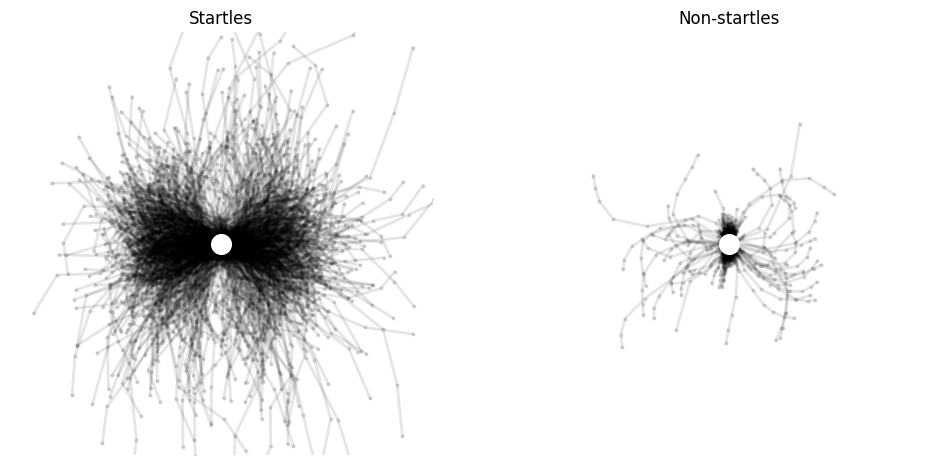

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
x_cT = x.T - x.T[f1]
y_cT = y.T - y.T[f1]
ax[0].plot(x_cT[f1:f2+1,startle],y_cT[f1:f2+1,startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[0]), ax[0].set_title("Startles")
ax[1].plot(x_cT[f1:f2+1,~startle],y_cT[f1:f2+1,~startle],'-o', markersize=2, color='k', alpha=0.1, lw=2), ax_format(ax[1]), ax[1].set_title("Non-startles")
ax[0].scatter(0,0,s=200,c="white",zorder=10)
ax[1].scatter(0,0,s=200,c="white",zorder=10)

#### Fig 1f | Single speaker playback

R, sp0, +1,+1
R, sp1, +1,+1


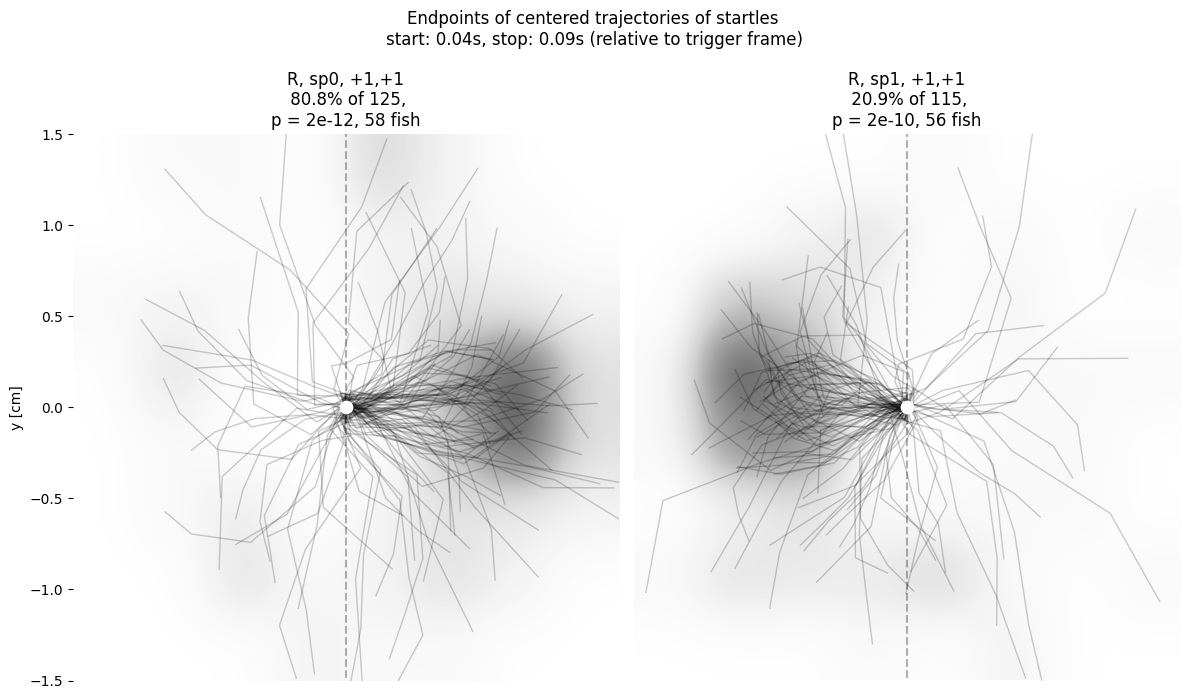

In [12]:
groupby = 'signal'
groups = ['R, sp0, +1,+1', 'R, sp1, +1,+1']
xaway = False
fig, ax = plot()

SingleSpeaker+1


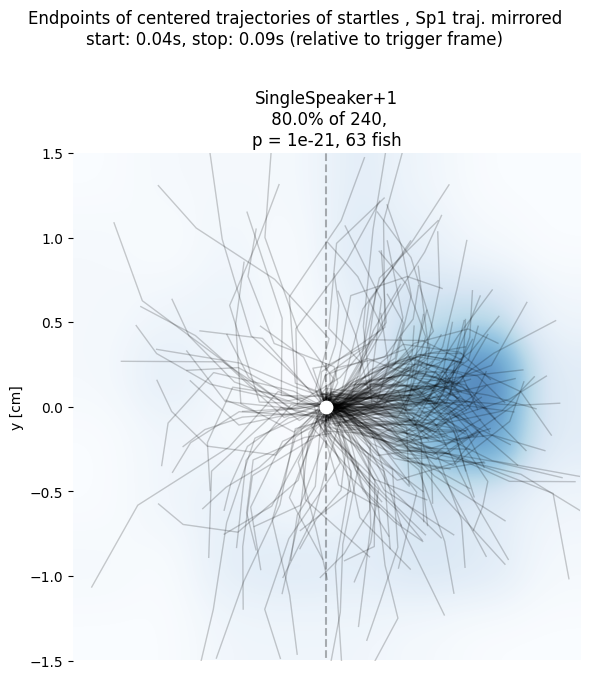

In [13]:
groupby = 'Pooled, Pressure Polarity'
groups = ['SingleSpeaker+1']
xaway = True
fig, ax = plot()

___

### Figure 2
For experimental set with lateral line ablation, compare Extended Data Fig 6b-d.

#### Fig 2d | Single speaker configurations

SingleSpeaker+1
SingleSpeaker-1


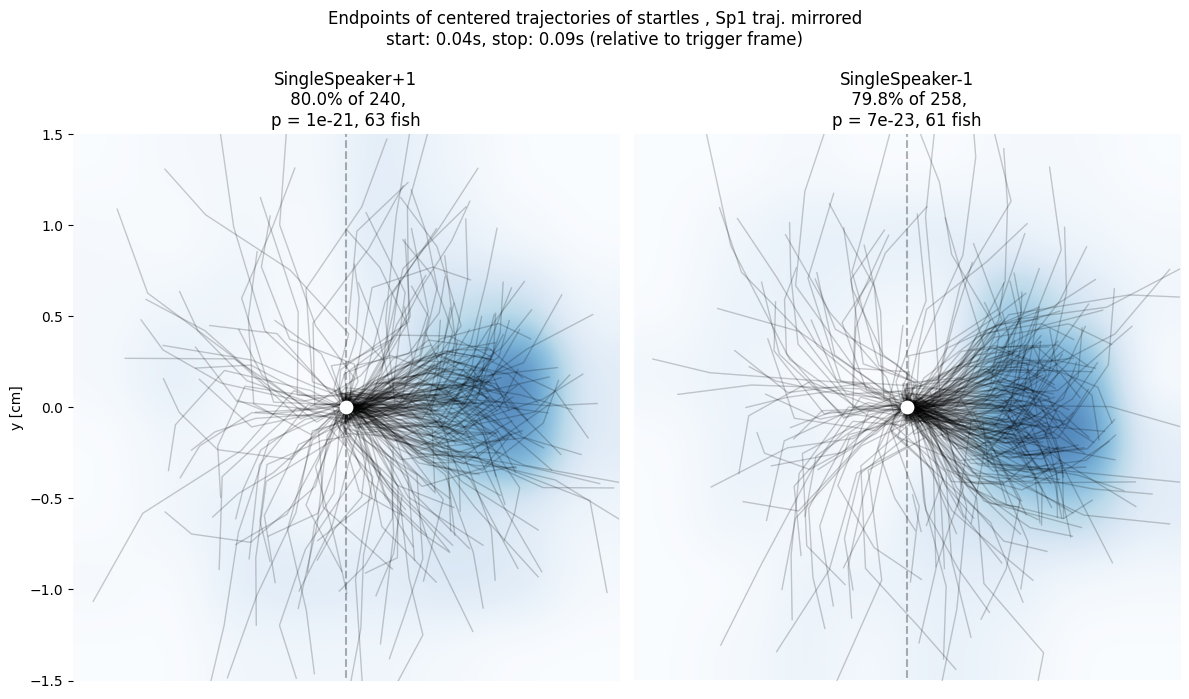

In [14]:
groupby = 'Pooled, Pressure Polarity'
groups = ['SingleSpeaker+1','SingleSpeaker-1']
xaway = True
fig, ax = plot()

#### Fig 2e | Pressure and motion configuration

R, sp0-4, +1,0
R, sp0-4, 0,+1


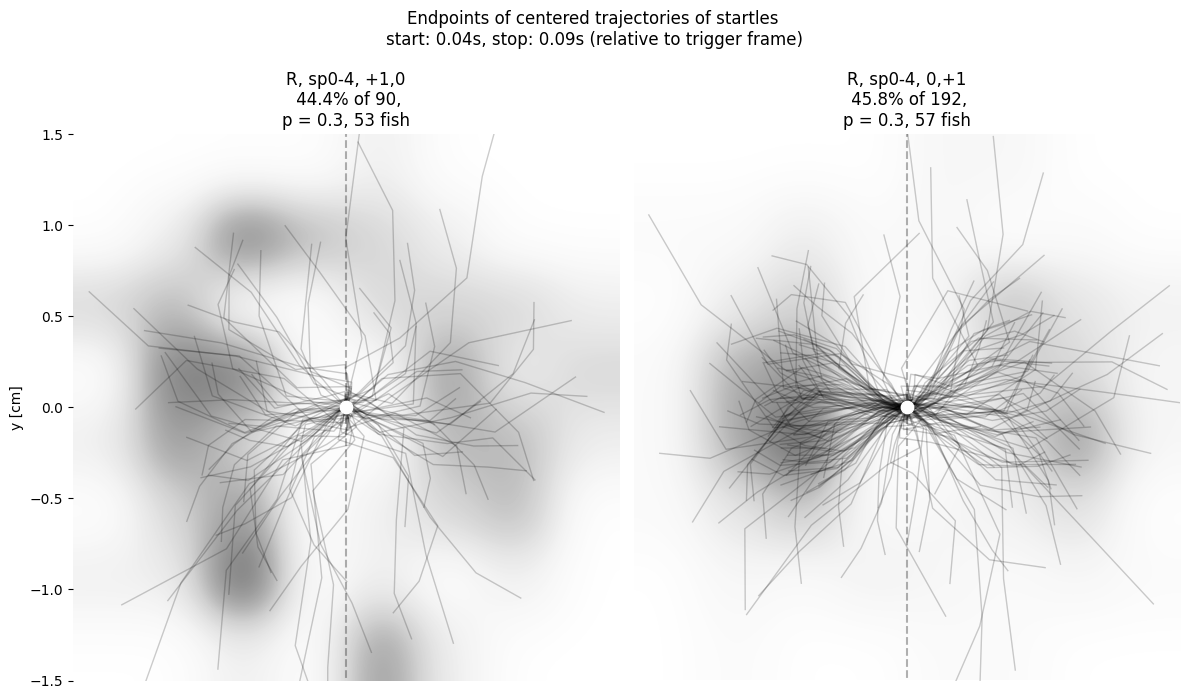

In [15]:
groupby = 'signal'
groups = ['R, sp0-4, +1,0','R, sp0-4, 0,+1']
xaway = False
fig, ax = plot()

#### Fig 2f | Trick configuration

SingleSpeaker
Trick


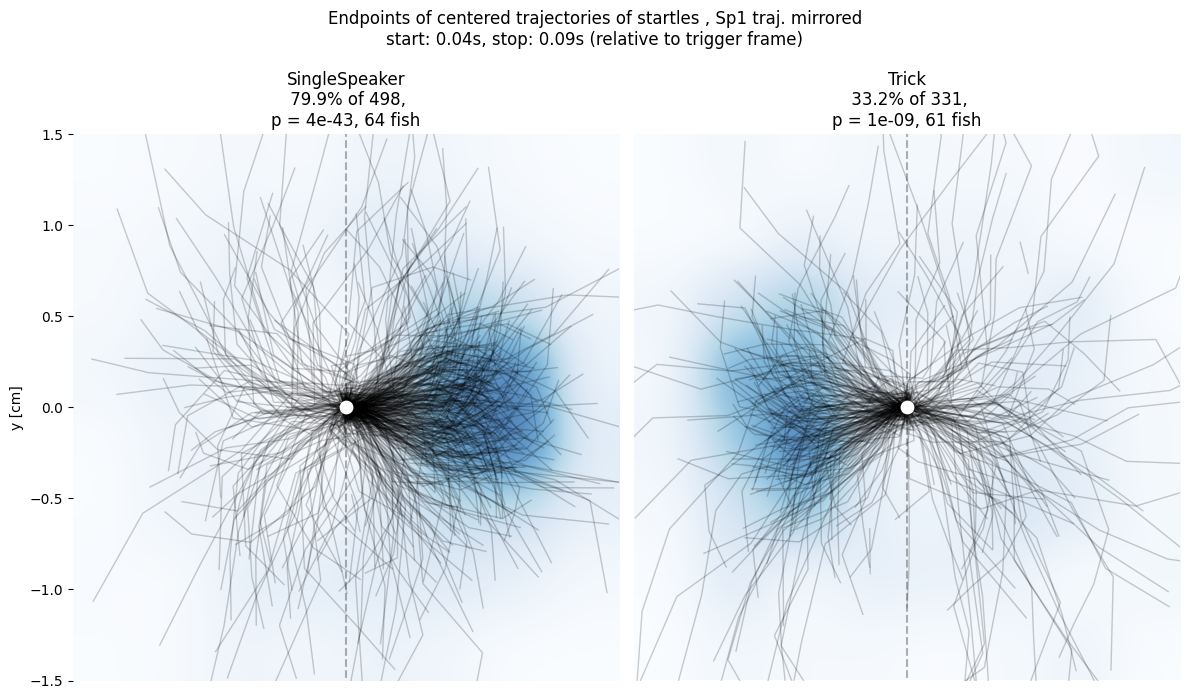

In [16]:
groupby = 'Pooled'
groups = ['SingleSpeaker', 'Trick']
xaway = True
fig, ax = plot()